<a href="https://colab.research.google.com/github/yuhui-0611/ESAA/blob/main/ESAA_YB_WEEK13_2_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5. DBSCAN

## DBSCAN (Density Based Spatial Clustering of Applications with Noise) 개요

- 아래 그림처럼 내부의 원 모양과 외부의 원 모양 형태의 분포를 가진 데이터 세트를 군집화한다고 가정할 때, K 평균, 평균이동, GMM으로는 효과적인 군집화 수행 곤란
- DBSCAN은 특정 공간 내에 데이터 밀도 차이를 기반 알고리즘으로 하고 있어서 복잡한 기하학적 분포도를 가진 데이터 세트에서도 군집화 잘 수행

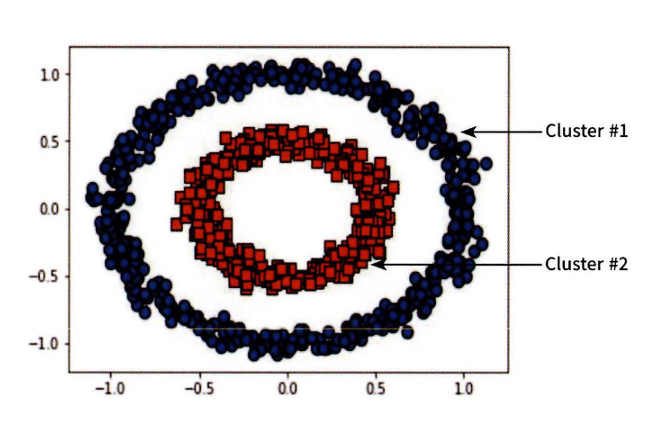

< DBSCAN 중요 파라미터 >
- 입실론 주변 영역 epsilon
> 개별  데이터를 중심으로 입실론 반경을 가지는 원형의 영역
- 최소 데이터 개수 min points
> 개별 데이터의 입실론 주변 영역에 포함되는 타 데이터의 개수

< 데이터 포인트 >
- 핵심 포인트(Core Point)
> 주변 영역 내에 최소 데이터 개수 이상의 타 데이터를 가지고 있을 경우의 해당 데이터
- 이웃 포인트(Neighbor Point)
> 주변 영역 내에 위치한 타 데이터
- 경계 포인트(Border Point)
> 주변 영역 내에 최소 데이터 개수 이상의 이웃 포인트를 가지고 있지 않지만 핵심 포인트를 이웃 포인트로 가지고 있는 데이터
- 잡음 포인트(Noise Point)
> 최소 데이터 개수 이상의 이웃 포인트를 가지고 있지 않으며, 핵심 포인트도 이웃 포인트로 가지고 있지 않는 데이터

**순서**

1. 특정 입실론 반경 내에 포함될 최소 데이터 세트를 6개로(자기 자신의 데이터를 포함) 가정하겠습니다.
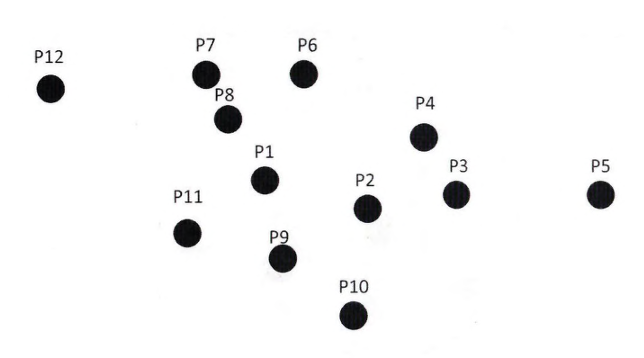

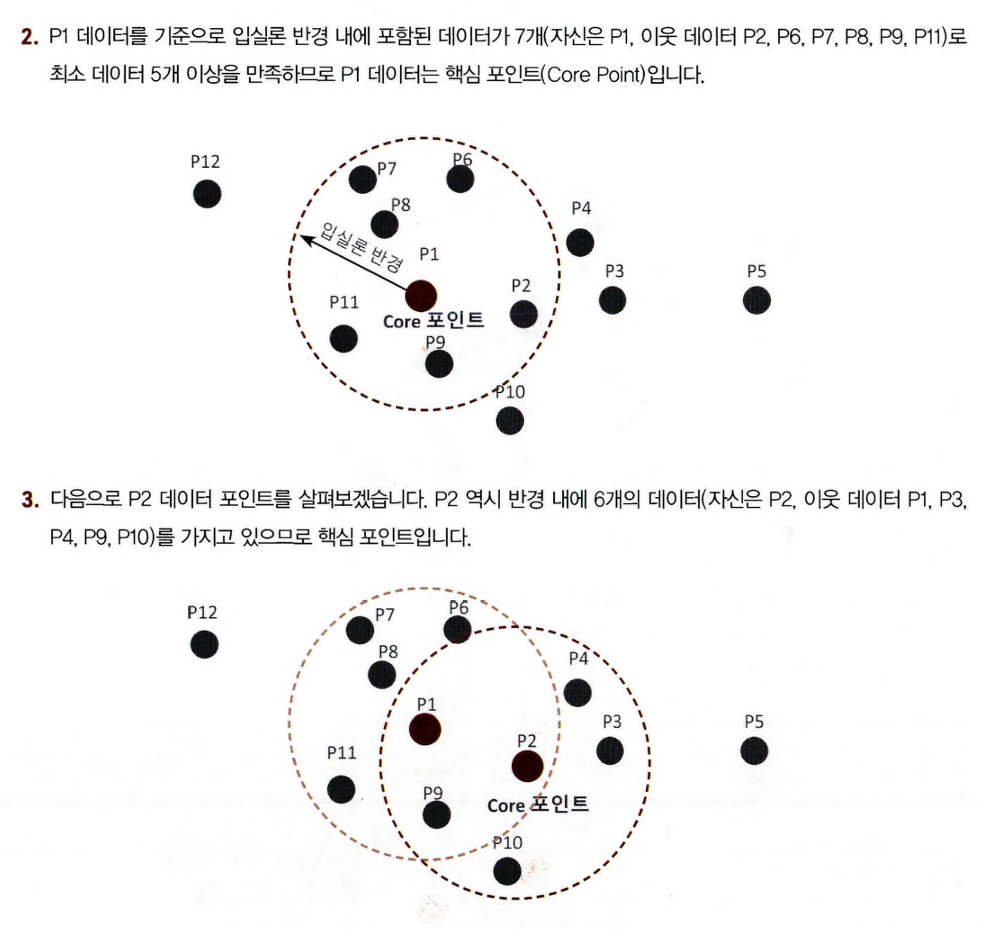

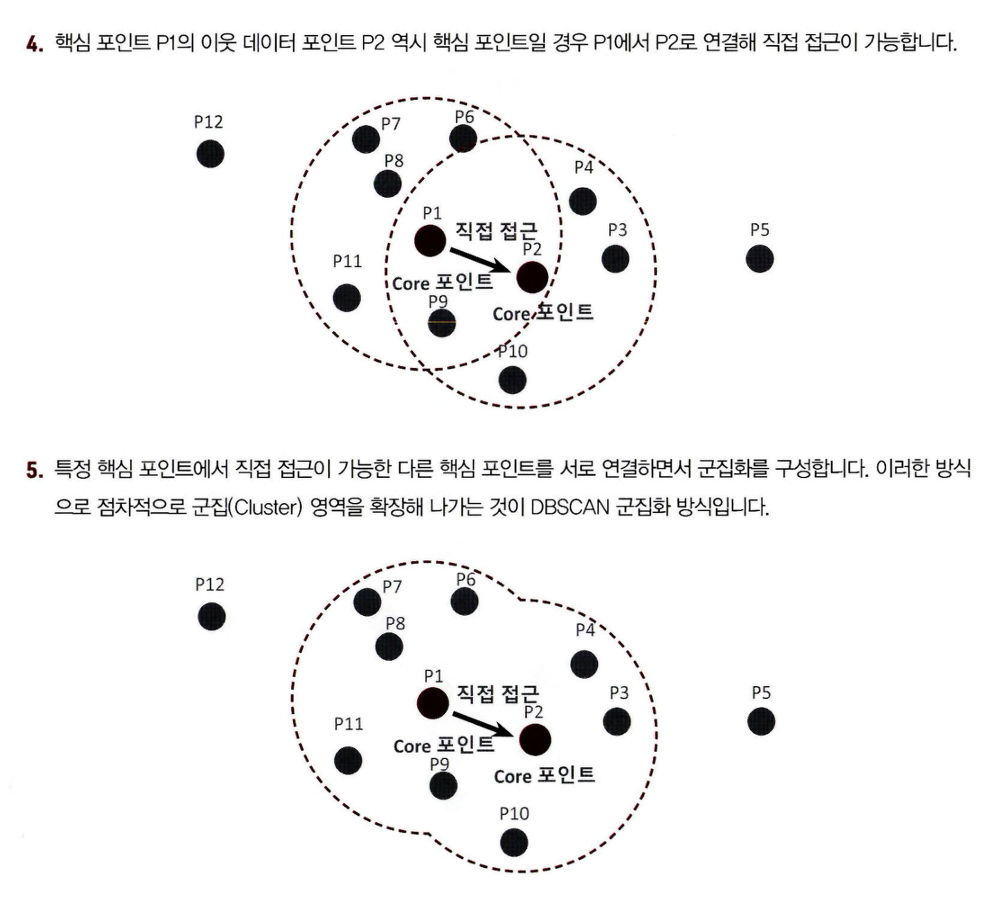

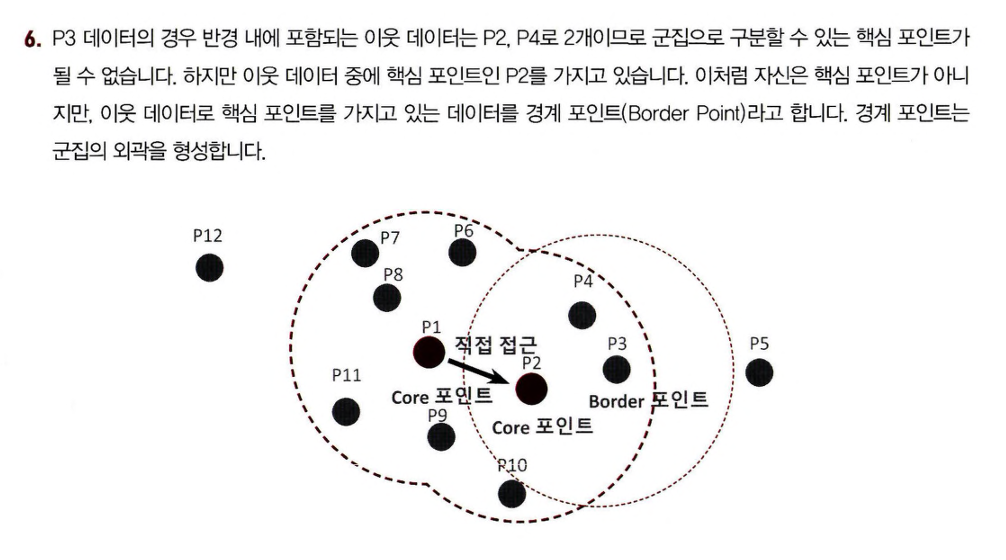

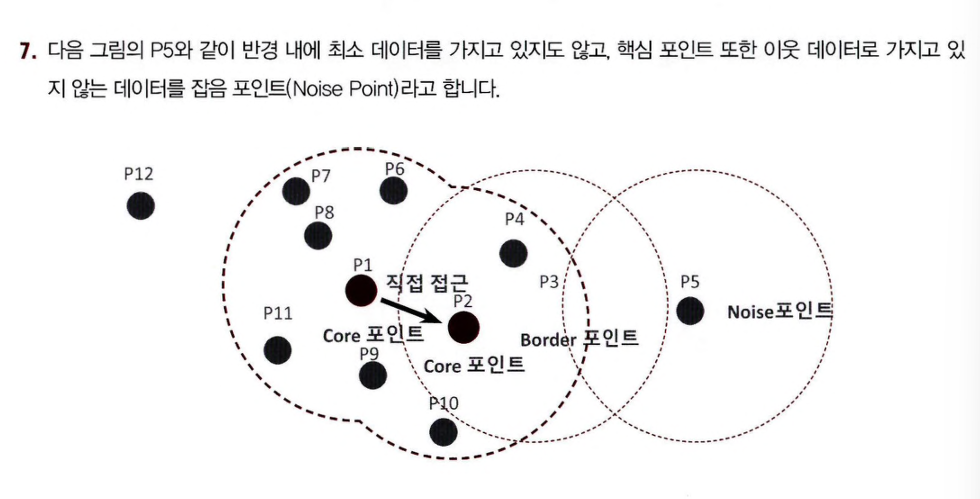

- DBSCAN은 이처럼 입실론 주변 영역의 최소 데이터 개수를 포함하는 밀도 기준을 충족시키는 데이터인 핵심 포인트를 연결하면서 군집화를 구성하는 방식

< DBSCAN 초기화 파라미터 >
-  eps
> 입실론 주변 영역의 반경을 의미
- min_samples
> 핵심 포인트가 되기 위해 입실론 주변 영역 내에 포함돼야 할 데이터의 최소 개수를 의미 (자신의 데이터를 포함, 위에서 설명한 min points + 1)

## DBSCAN 적용하기 - 붓꽃 데이터 세트

In [1]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# 좀 더 편리한 데이터 Handling을 위해 DataFrame으로 변환
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target'] = iris.target

In [2]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.6, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

target  dbscan_cluster
0        0                49
        -1                 1
1        1                46
        -1                 4
2        1                42
        -1                 8
Name: count, dtype: int64


- 군집 레이블이 -1인 것은 노이즈에 속하는 군집을 의미
- 따라서 위 붓꽃 데이터 세트는 DBSCAN에서 0과 1 두 개의 군집으로 군집화된 것
- Target 값의 유형이 3가지인데, 군집이 2개가 됐다고 군집화 효율이 떨어진다는 의미는 아님
- DBSCAN은 군집의 개수를 알고리즘에 따라 자동으로 지정하므로, DBSCAN에서 군집의 개수를 지정하는 것은 무의미
- 특히 붓꽃 데이터 세트는 군집을 3개로 하는 것보다 2개로 하는 것이 군집화의 효율로서 더 좋은 것

In [3]:
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_

    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)

        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,
                    edgecolor='k', marker=markers[label], label=cluster_legend)

        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',
                        edgecolor='k', marker='' % label)
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'

    plt.legend(loc=legend_loc)
    plt.show()

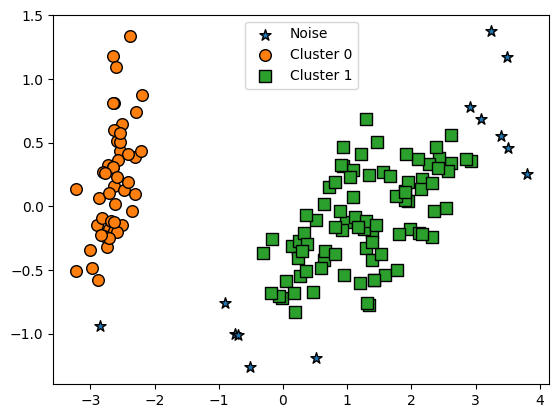

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=0)
pca_transformed = pca.fit_transform(iris.data)
irisDF['ftr1'] = pca_transformed[:,0]
irisDF['ftr2'] = pca_transformed[:,1]

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

- 별 = 노이즈
- PCA로 2차원으로 표현하면 이상치인 노이즈 데이터가 명확히 드러남
- DBSCAN을 적용할 때는 특정 군집 개수로 군집을 강제하지 않는 것이 good
- DBSCAN 알고리즘에 적절한 eps와 min_samples 파라미터를 통해 최적의 군집을 찾는 게 중요
- 일반적으로 eps의 값을 크게 하면 반경이 커져 포함하는 데이터가 많아지므로 노이즈 데이터 개수가 작아짐
- min_samples를 크게 하면 주어진 반경 내에서 더 많은 데이터를 포함시켜야 하므로 노이즈 데이터 개수가 커짐
> 데이터 밀도가 더 커져야 하는데, 매우 촘촘한 데이터 분포가 아닌 경우 노이즈로 인식하기 때문

target  dbscan_cluster
0        0                50
1        1                50
2        1                47
        -1                 3
Name: count, dtype: int64


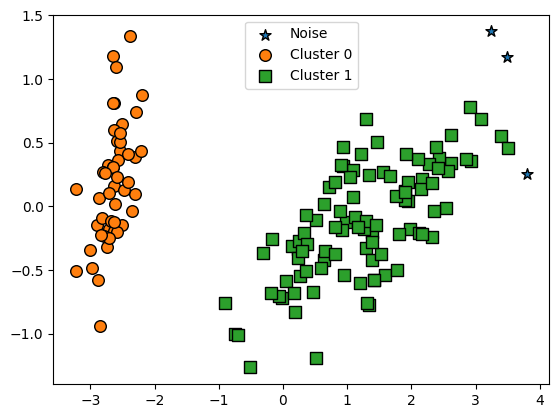

In [5]:
# eps 증가
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.8, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

target  dbscan_cluster
0        0                48
        -1                 2
1        1                44
        -1                 6
2        1                36
        -1                14
Name: count, dtype: int64


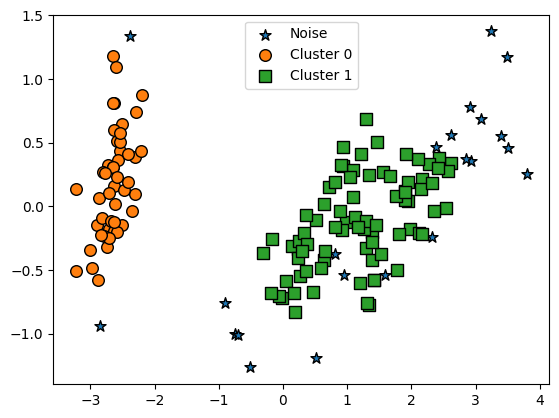

In [6]:
# min_samples 증가
dbscan = DBSCAN(eps=0.6, min_samples=16, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

## DBSCAN 적용하기 - make_circles() 데이터 세트

- make_circles() 함수를 이용해 내부 원과 외부 원 형태로 돼 있는 2차원 데이터 세트 만듦
> make_circles() 함수는 오직 2개의 피처만을 생성하므로 별도의 피처 개수를 지정할 필요 X
- 파라미터 noise는 노이즈 데이터 세트의 비율, factor는 외부 원과 내부 원의 scale 비율

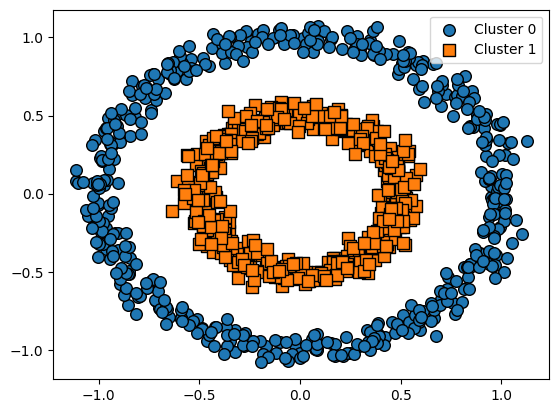

In [7]:
from sklearn.datasets import make_circles

X,y = make_circles(n_samples=1000, shuffle=True, noise=0.05, random_state=0, factor=0.5)
clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

/tmp/ipython-input-3623408909.py:24: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',


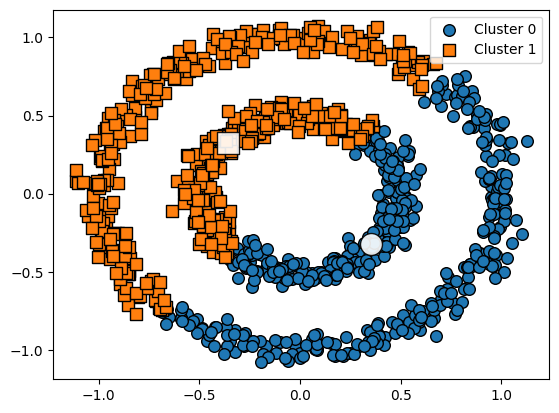

In [8]:
# KMeans로 make_circles( ) 데이터 세트를 군집화 수행
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, max_iter=1000, random_state=0)
kmeans_labels = kmeans.fit_predict(X)
clusterDF['kmeans_cluster'] = kmeans_labels

visualize_cluster_plot(kmeans, clusterDF, 'kmeans_cluster', iscenter=True)

- 위, 아래 군집 중심을 기반으로 위와 아래 절반으로 군집화됨
- 즉, 거리 기반 군집화로는 위와 같이 데이터가 특정한 형태로 지속해서 이어지는 부분을 찾아내기 곤란

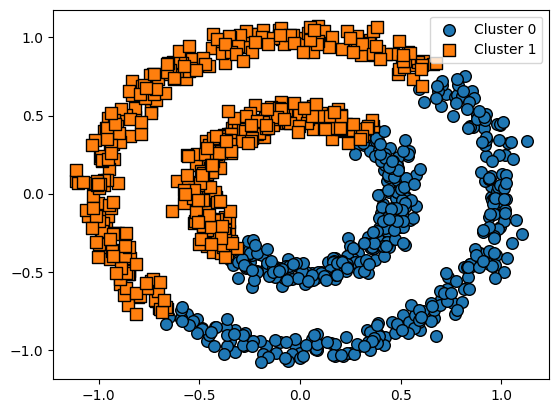

In [9]:
# GMM으로 make_circles( ) 데이터 세트를 군집화 수행
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=0)
gmm_label = gmm.fit(X).predict(X)  # = gmm.fit_predict(X)
clusterDF['gmm_cluster'] = gmm_label

visualize_cluster_plot(gmm, clusterDF, 'gmm_cluster', iscenter=False)

- GMM도 앞 절의 일렬로 늘어선 데이터 세트에서는 효과적으로 군집화 적용이 가능했으나, 내부와 외부의 원형으로 구성된 더 복잡한 형태의 데이터 세트에서는 군집화가 원하는 방향으로 되지 않음

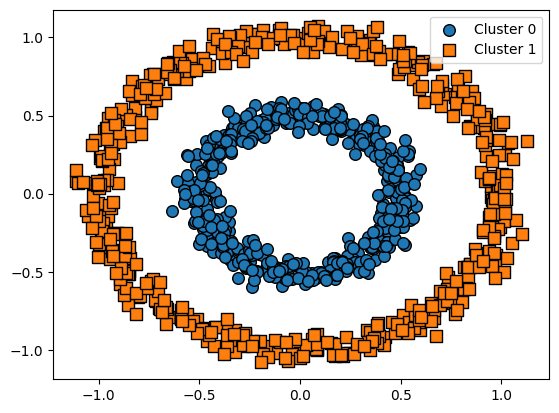

In [10]:
# DBSCAN으로 make_circles() 데이터 세트 군집화 수행
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=10, metric='euclidean')
dbscan_labels = dbscan.fit_predict(X)
clusterDF['dbscan_cluster'] = dbscan_labels
visualize_cluster_plot(dbscan, clusterDF, 'dbscan_cluster', iscenter=False)

# 6. 군집화 실습 - 고객 세그먼테이션

## 고객 세그먼테이션의 정의와 기법

고객 세그먼테이션
- 다양한 기준으로 고객을 분류하는 기법
- CRM, 마케팅의 중요 기반 요소
- 목표 = 타깃 마케팅
> 고객을 여러 특성에 맞게 세분화하여 그 유형에 따라 맞춤형 마케팅이나 서비스를 제공하는 것

< 고객 분석 요소 RFM 기법 >

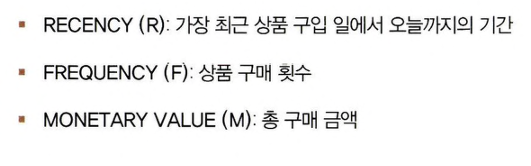

## 데이터 세트 로딩과 데이터 클렌징

In [11]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as pit
%matplotlib inline

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
retail_df = pd.read_excel(io='/content/drive/MyDrive/ESAA/Online Retail.xlsx')
retail_df.head(3)

InvoiceNo StockCode                         Description  Quantity  \
0    536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                 WHITE METAL LANTERN         6   
2    536365    84406B      CREAM CUPID HEARTS COAT HANGER         8   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom

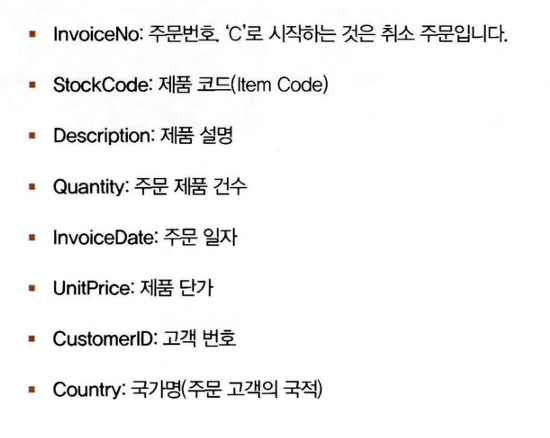

In [14]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


- Null 데이터 제거 : 특히 CustomerlD가 Null인 데이터가 많기에 고객 식별 번호가 없는 데이터는 삭제
- 오류 데이터 삭제 : 대표적인 오류 데이터는 Quantity 또는 UnitPrice가 0보다 작은 경우
> Quantity가 0보다 작은 경우는 오류 데이터라기보다는 반환을 뜻하는 값이며, 이 경우 InvoiceNo의 앞자리는 'C'로 돼 있기에 이 데이터는 모두 삭제
- 불린 인덱싱을 적용해 Quantity > 0, UnitPrice > 0 이고, CustomerlD가 Not Null인 값만 다시 필터링

In [15]:
retail_df = retail_df[retail_df['Quantity']>0]
retail_df = retail_df[retail_df['UnitPrice']>0]
retail_df = retail_df[retail_df['CustomerID'].notnull()]
print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [16]:
retail_df['Country'].value_counts()[:5]

Country
United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Name: count, dtype: int64

In [17]:
retail_df = retail_df[retail_df['Country']=='United Kingdom']
print(retail_df.shape)

(354321, 8)


## RFM 기반 데이터 가공

In [18]:
# 주문 금액 데이터
retail_df['sale_amount'] = retail_df['Quantity'] * retail_df['UnitPrice']

# 편리한 식별성을 위해 float를 int로 변경
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

In [19]:
# Top5 주문 건수와 주문 금액을 가진 고객 데이터 추출
print(retail_df['CustomerID'].value_counts().head(5))
print(retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False)[:5])

CustomerID
17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: count, dtype: int64
CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64


- 지금 수행하려는 RFM 기반의 고객 세그먼테이션은 고객 레벨로 주문 기간, 주문 횟수, 주문 금액 데이터를 기반으로 해 세그먼테이션을 수행하는 것
- 이에 주문번호+상품코드 기준의 데이터를 고객 기준의 Recency, Frequency, Monetary value 데이터로 변경
- 이를 위해서는 주문번호 기준의 데이터를 개별 고객 기준의 데이터로 Group by 해야함

> 주문번호 기준의 retail_df DataFrame에 groupby('CustomerlD')를 적용해 CustomerlD 기준으로 DataFrame을 새롭게 생성

In [20]:
retail_df.groupby(['InvoiceNo','StockCode'])['InvoiceNo'].count().mean()

np.float64(1.028702077315023)

- agg( )에 인자로 대상 칼럼들과 aggregation 함수명들을 딕셔너리 형태로 입력하면 칼럼 여러 개의 서로 다른 aggregation 연산을 쉽게 수행

In [21]:
# DataFrame의 groupby()의 multiple 연산을 위해 agg() 이용
aggregations = {
    'InvoiceDate': 'max',
    'InvoiceNo': 'count',
    'sale_amount': 'sum'
}
cust_df = retail_df.groupby('CustomerID').agg(aggregations)
cust_df.head(3)

InvoiceDate  InvoiceNo  sale_amount
CustomerID                                            
12346      2011-01-18 10:01:00          1     77183.60
12747      2011-12-07 14:34:00        103      4196.01
12748      2011-12-09 12:20:00       4595     33719.73

In [22]:
# groupby된 결과 칼럼 값을 Recency, Frequency, Monetary로 변경
cust_df = cust_df.rename(columns = {'InvoiceDate': 'Recency',
                                    'InvoiceNo': 'Frequency',
                                    'sale_amount': 'Monetary'})

cust_df = cust_df.reset_index()
cust_df.head(3)

CustomerID             Recency  Frequency  Monetary
0       12346 2011-01-18 10:01:00          1  77183.60
1       12747 2011-12-07 14:34:00        103   4196.01
2       12748 2011-12-09 12:20:00       4595  33719.73

- Recency는 고객이 가장 최근에 주문한 날짜 기반
> 오늘 날짜를 기준으로 가장 최근 주문 일자를 뺀 날짜
- 온라인 판매 데이터 = '2010년 12월 1일 ~ 2011년 12월 9일'까지의 데이터이므로 오늘 날짜는 2011년 12월 9일에서 하루 더한 2011년 12월 10일로 지정
- 2011년 12월 10일을 현재 날짜로 간주하고 가장 최근의 주문 일자를 뺀 데이터에서 일자 데이터(days)만 추출해 생성

In [23]:
import datetime as dt

cust_df['Recency'] = dt.datetime(2011,12,10) - cust_df['Recency']
print(cust_df.shape)
cust_df.head(3)

(3920, 4)


CustomerID           Recency  Frequency  Monetary
0       12346 325 days 13:59:00          1  77183.60
1       12747   2 days 09:26:00        103   4196.01
2       12748   0 days 11:40:00       4595  33719.73

In [24]:
cust_df['Recency'] = cust_df['Recency'].apply(lambda x: x.days+1)
cust_df.head(3)

CustomerID  Recency  Frequency  Monetary
0       12346      326          1  77183.60
1       12747        3        103   4196.01
2       12748        1       4595  33719.73

- x = 325 days 13:59:00 같은 timedelta 객체
- x.days : timedelta에서 정수 일(day)만 추출

## RFM 기반 고객 세그먼테이션

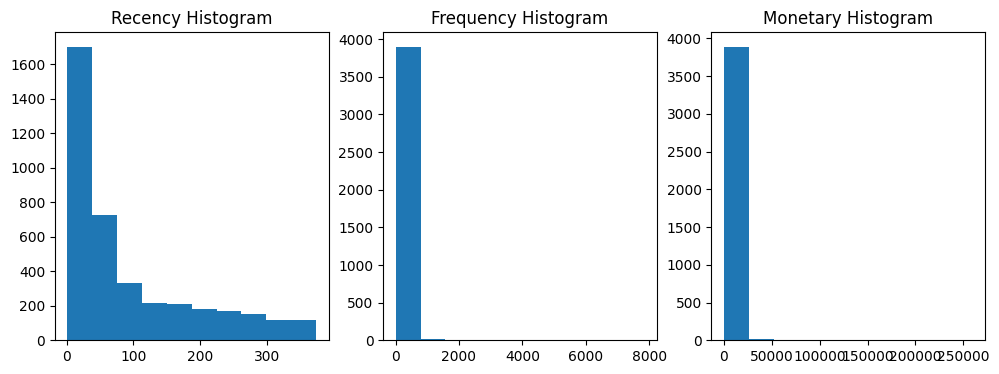

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])
plt.show()

In [26]:
cust_df[['Recency', 'Frequency', 'Monetary']].describe()

Recency    Frequency       Monetary
count  3920.000000  3920.000000    3920.000000
mean     92.742092    90.388010    1864.385601
std      99.533485   217.808385    7482.817477
min       1.000000     1.000000       3.750000
25%      18.000000    17.000000     300.280000
50%      51.000000    41.000000     652.280000
75%     143.000000    99.250000    1576.585000
max     374.000000  7847.000000  259657.300000

< Recency >
- 평균이 92.7이지만, 50%인 51보다 크게 높음
- max 값은 374로 75%인 143보다 훨씬 커서 왜곡 정도가 높음

< Frequency >
- 평균이 90.3인데, 75%인 99.25에 가까움
- max 값 7847을 포함한 상위 몇 개의 큰 값으로 인한 것

< Monetary >
- 평균은 1864.3으로 75%인 1576.5보다 매우 큼
- 이는 max 값 259657.3을 포함한 상위 몇 개의 큰 값으로 인해 발생한 현상

< K 평균 >
- 왜곡 정도가 매우 높은 데이터 세트에 K-평균 군집을 적용하면 중심의 개수를 증가시키더라도 변별력이 떨어지는 군집화가 수행됨

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features = cust_df[['Recency', 'Frequency', 'Monetary']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('Silhouette Score: {:.3f}'.format(silhouette_score(X_features_scaled, labels)))

Silhouette Score: 0.576


- 실루엣 스코어 안정적 수치

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def visualize_silhouette(cluster_list, X):
    from matplotlib import pyplot as plt

    for n_clusters in cluster_list:
        fig, ax1 = plt.subplots(1)
        fig.set_size_inches(6, 4)

        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        kmeans = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = kmeans.fit_predict(X)

        silhouette_vals = silhouette_samples(X, cluster_labels)
        silhouette_avg = silhouette_score(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_silhouette_vals = silhouette_vals[cluster_labels == i]
            ith_silhouette_vals.sort()

            size_cluster_i = ith_silhouette_vals.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_silhouette_vals,
                              facecolor=color, edgecolor=color, alpha=0.7)

            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_title(f"Silhouette plot for {n_clusters} clusters")
        ax1.set_xlabel("Silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        plt.tight_layout()
        plt.show()

In [29]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
import numpy as np

def visualize_kmeans_plot_multi(cluster_list, X_features):
    n_cols = len(cluster_list)
    fig, axes = plt.subplots(figsize=(5 * n_cols, 4), nrows=1, ncols=n_cols)

    for i, n_cluster in enumerate(cluster_list):
        clusterer = KMeans(n_clusters=n_cluster, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        # 시각화
        ax = axes[i]
        sns.scatterplot(x=X_features[:, 0], y=X_features[:, 1],
                        hue=cluster_labels, palette='Set2', ax=ax, legend=False)
        ax.set_title(f'KMeans Clustering: {n_cluster} clusters')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')

    plt.tight_layout()
    plt.show()

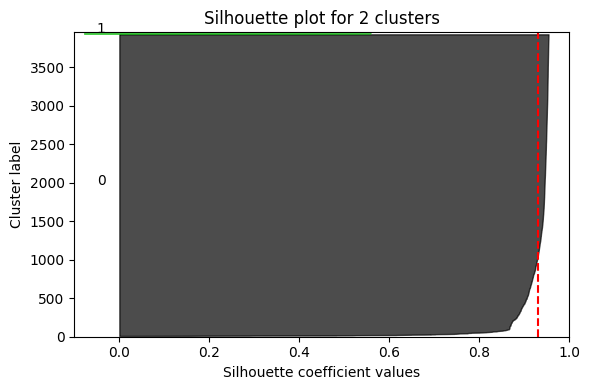

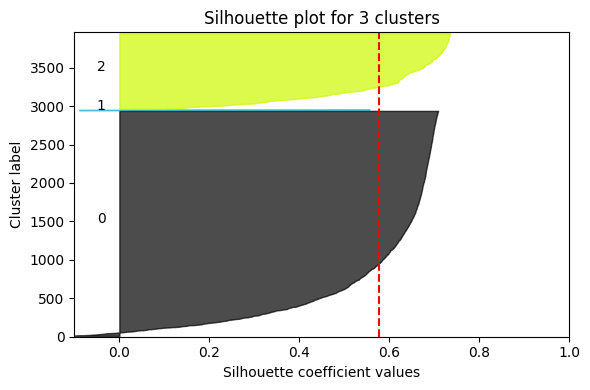

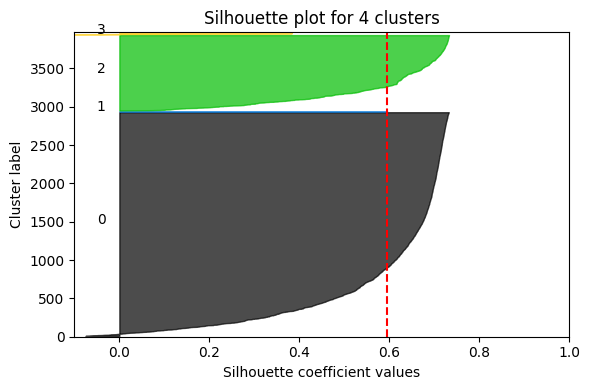

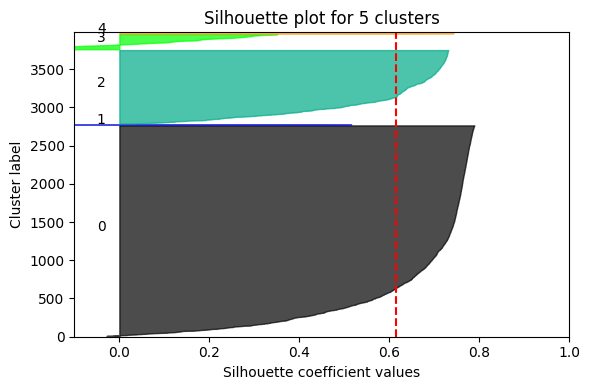

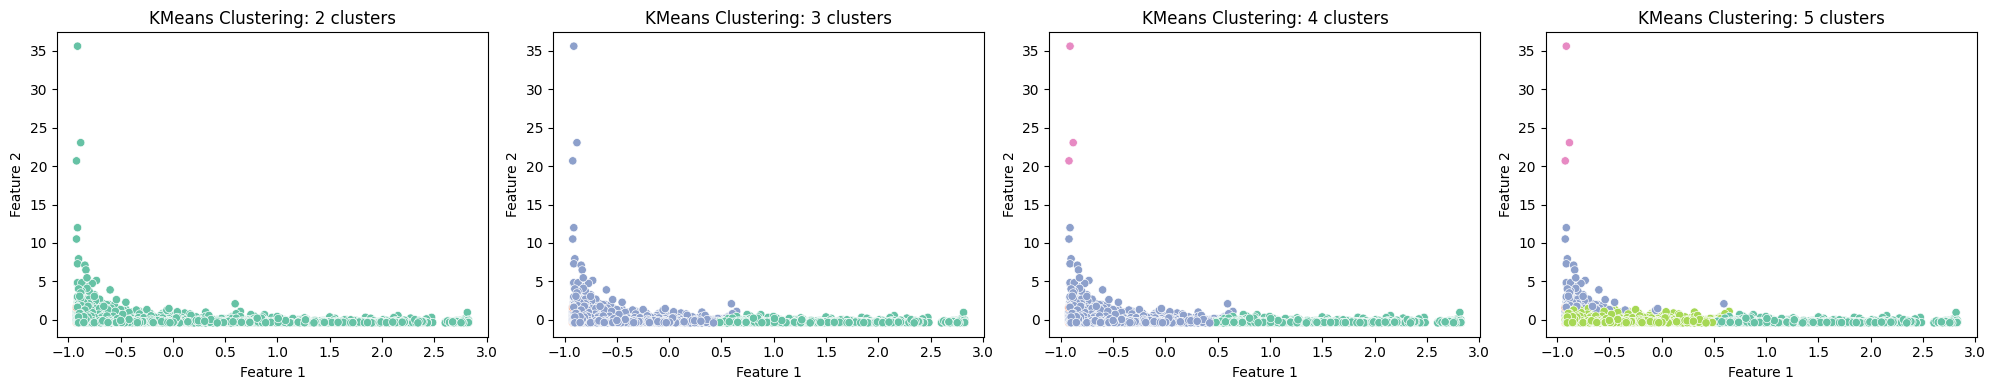

In [30]:
visualize_silhouette([2,3,4,5], X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5], X_features_scaled)

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

X_features = cust_df[['Recency_log', 'Frequency_log', 'Monetary_log']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('silhouette: {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

silhouette: 0.303


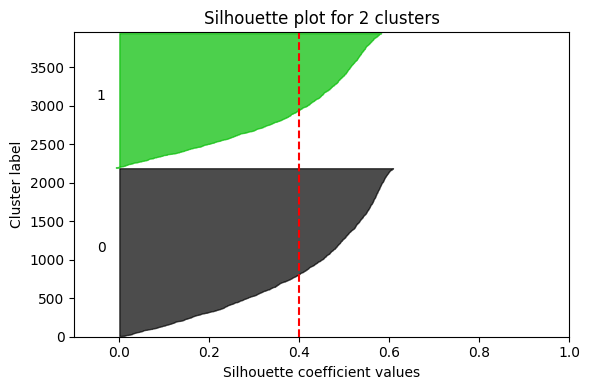

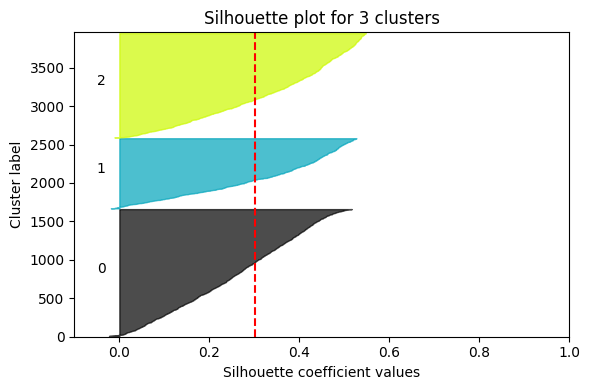

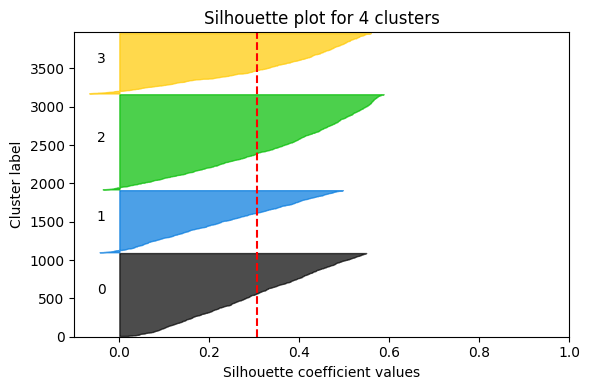

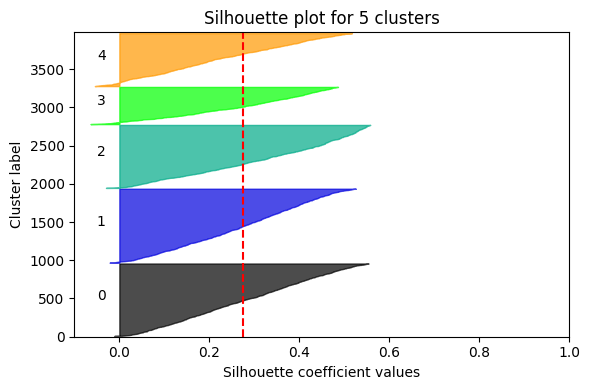

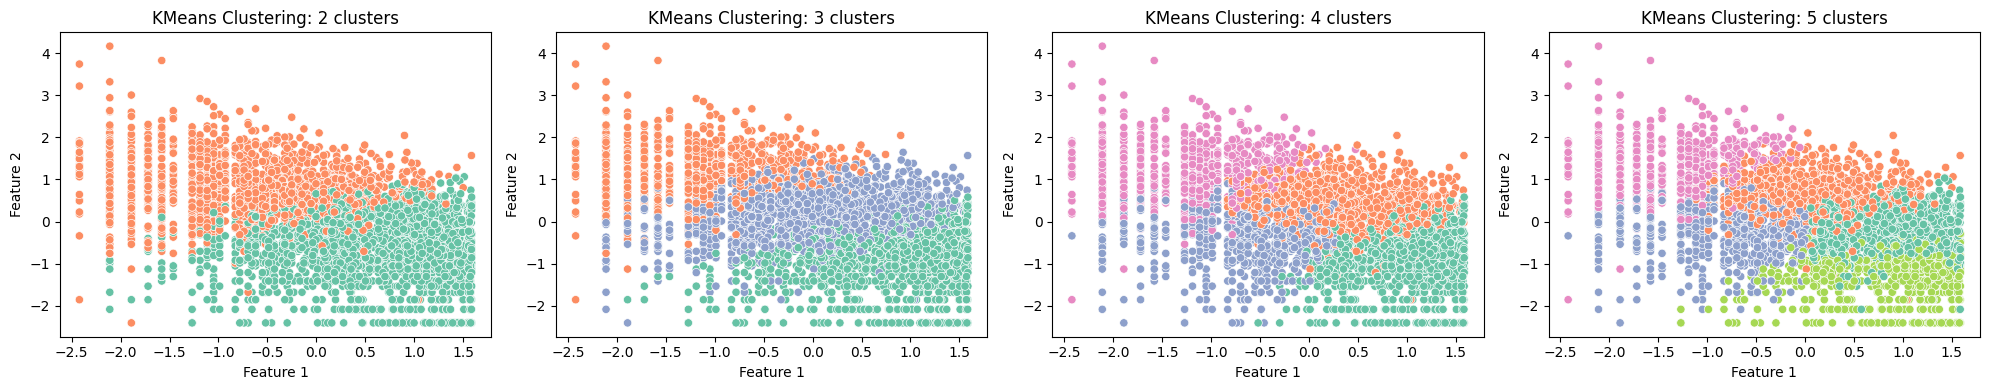

In [33]:
visualize_silhouette([2,3,4,5], X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5], X_features_scaled)

# 정리

**< K-평균 >**
- 경우 거리 기반으로 군집 중심점을 이동시키면서 군집화를 수행
- 매우 쉽고 직관적인 알고리즘으로 많은 군집화 애플리케이션에서 애용되지만, 복잡한 구조를 가지는 데이터 세트에 적용하기에는 한계가 있으며, 군집의 개수를 최적화하기가 어려움
- K-평균은 군집이 잘 되었는지의 평가를 위해 실루엣 계수 이용

**< 평균 이동(Mean Shift) >**
- K-평균과 유사하지만 거리 중심이 아니라 데이터가 모여 있는 밀도가 가장 높은 쪽으로 군집 중심점을 이동하면서 군집화를 수행
- 일반 업무 기반의 정형 데이터 세트보다는 컴퓨터 비전 영역에서 이미지나 영상 데이터에서 특정 개체를 구분하거나 움직임을 추적하는 데 뛰어난 역할을 수행하는 알고리즘

**< GMM(Gaussian Mixture Model) >**
- 군집화를 적용하고자 하는 데이터가 여러 개의 가우시안 분포(Gaussian Distribution)를 모델을 섞어서 생성된 모델로 가정해 수행하는 방식
- 전체 데이터 세트에서 서로 다른 정규 분포 형태를 추출해 이렇게 다른 정규 분포를 가진 데이터 세트를 각각 군집화하는 것
- K-평균보다 유연하게 다양한 데이터 세트에 잘 적용될 수 있지만, 군집화를 위한 수행 시간이 오래 걸림

**< DBSCAN(Density Based Spatial Clustering of Applications with Noise) >**
- 밀도 기반 군집화의 대표적인 알고리즘
- 입실론 주변 영역 내에 포함되는 최소 데이터 개수의 충족 여부에 따라 데이터 포인트를 핵심 포인트, 이웃 포인트, 경계 포인트, 잡음 포인트로 구분하고 특정 핵심 포인트에서 직접 접근이 가능한 다른 핵심 포인트를 서로 연결하면서 군집화를 구성
- DBSCAN은 간단하고 직관적인 알고리즘으로 돼 있음에도 데이터의 분포가 기하학적으로 복잡한 데이터 세트에도 효과적인 군집화가 가능